# `011` Convolutional Neural Networks

Requirements: 007 Initialization, 008 Batch normalization

With the MLP architectures we have seen so far, we take a set of input features, make linear combinations of them, and then apply a non-linear function to the result. This is very flexible, but often we want to take advantage of the structure of the input data. For example, in images, we know that pixels that are close to each other are more likely to be related than pixels that are far apart. Convolutional Neural Networks (CNNs) are a type of neural network that takes advantage of this structure.

In the 50s, Hubel and Wiesel discovered that the area of the brain that processes visual information had areas that respond individually to small regions of the visual field. They also discovered that some neurons responded to edges, others to corners, and so on. This led to the idea that the brain processes visual information in a hierarchical way, with simple features being detected first, and then more complex features being built on top of them.

CNNs are inspired by this idea. They have a series of layers, each of which is made up of a number of filters. Each filter is a small matrix that is applied to the input data. The output of the filter is a new matrix that is the result of applying the filter to the input data. The filters are learned during training, so the network can learn to detect different features in the input data.

Let's consider the following image:

In [1]:
from PIL import Image
from time import time
import torch
import torchvision

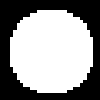

In [2]:
img = torch.meshgrid(torch.arange(-15, 15), torch.arange(-15, 15), indexing='ij')
img = (img[0]**2 + img[1]**2 < 13**2).float()

# display a 10-sized version of the image
Image.fromarray(img.numpy().astype('uint8') * 255).resize((100, 100), Image.NEAREST)

For detecting the borders of an image like this, we need to apply two filters: one for detecting vertical borders and another for detecting horizontal borders. For instance, this is the vertical border filter:

```
1  0 -1
1  0 -1
1  0 -1
```

Applying a filter means starting on the top-right corner, taking a crop of the image with the same size as the filter (this is called the **window**), multiplying the values of the filter by the values of the image, and summing the results. This sum is the value of the output matrix at the top-right corner. Then we move the window one pixel to the right and repeat the process. When we reach the end of the row, we move the window to the leftmost pixel of the next row and repeat the process. Sliding the window through the image in this way is called a **convolution**.

Intuitively, if we are looking at a window like this one:

```
1 1 1
2 2 1
1 1 3
```

When doing the pairwise multiplication by the filter we'll obtain the following matrix:

```
1 0 -1
2 0 -1
1 0 -3
```

Since we are going to sum all elements, that means that:
* We don't care about the middle column of the window
* When we sum the first row we obtain a zero, because the first row of the original window is unchanged, i.e. it doesn't have a border.
* When we sum the second row we obtain a 1, because there is some difference between the first and second row of the window.
* When we sum the third row we obtain a -2, because there is some difference between the second and third row of the window. Note that a negative value means that the border has its darker side on the left.
* When adding up all numbers we obtain -1, which is the value of the output matrix at the pixel in the center of the pixel.

Let's run this convolution over the full image.

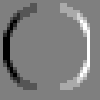

In [3]:
filter = torch.tensor([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
output = torch.zeros(img.shape)
for x in range(0, img.shape[0] - 3):
	for y in range(0, img.shape[1] - 3):
		output[x, y] = (img[x:x+3, y:y+3] * filter).sum()
output = 255 * (output - output.min()) / (output.max() - output.min())
Image.fromarray(output.numpy().astype('uint8')).resize((100, 100), Image.NEAREST)

And just like that, we have detected the vertical borders of the image. We can do the same thing with a filter that detects horizontal borders, but this time we'll let torch do the for loops for us.

torch.Size([30, 30])


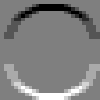

In [4]:
filter = torch.tensor([[1, 1, 1], [0, 0, 0], [-1, -1, -1]]).float()
print(img.shape)  # torch.Size([30, 30])
output = torch.conv2d(img[None, None, :, :], filter[None, None, :, :])
output = 255 * (output - output.min()) / (output.max() - output.min())
Image.fromarray(output[0, 0].numpy().astype('uint8')).resize((100, 100), Image.NEAREST)

We could stack the result of both filters to get a 3D matrix with two channels, one for each filter. This is called a **feature map**. We could then take the feature map and apply more convolutions, this time 3-dimensional, to detect more complex features. For instance, we could create a feature that represents the direction of the border, knowing that $atan2(\text{vertical border}, \text{horizontal border})$ will give us the direction of the border.

This is the idea behind CNNs and its success on image processing. The only difference is that in practice the filters are not hand-crafted, but learned during training. There are a few hyperparameters involved in a convolutional layer:
* The number of filters
* The size of the filters: typically, filters are square matrices with odd dimensions, like 3x3 or 5x5.
* The stride: how many pixels we move the window at each step. A stride of 1 means that we move the window one pixel at a time, a stride of 2 means that we move the window two pixels at a time, and so on.
* Padding: what we do when the window reaches the edge of the image. We can either ignore the pixels that are outside the image, or we can pad the image with zeros so that the window can slide all the way to the edge. By default, PyTorch uses zero padding.

In [5]:
train = torchvision.datasets.MNIST(root='data', download=True)
test = torchvision.datasets.MNIST(root='data', download=True, train=False)
x = train.data.float()
xt = test.data.float()
y = torch.nn.functional.one_hot(train.targets).float()
yt = torch.nn.functional.one_hot(test.targets).float()
print(f'Train: {x.shape}, test: {xt.shape}')

Train: torch.Size([60000, 28, 28]), test: torch.Size([10000, 28, 28])


One last key ingredient before stacking a bunch of convolutional filters together is the pooling layer. In the end, our goal with convolutional layers is to detect features in the input data. Same as in the brain equivalent, we need to create a hierarchy of features, starting from simple features and building more complex features on top of them. The pooling layer takes a window of the input data and applies a function to it, like the maximum or the average. This reduces the size of the input data, which compressed the information and makes the network more robust to small changes in the input data.

In [6]:
class DigitRecognizer(torch.nn.Module):
	def __init__(self):
		super().__init__()
		# take the input (B x 28 x 28), add a channel dimension (B x 1 x 28 x 28) and apply a 3x3 convolution with 8 filters
		self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3, padding=1)
		# apply a 2x2 max pooling -> B x 8 x 14 x 14
		self.pool1 = torch.nn.MaxPool2d(2)
		# apply a 3x3 convolution with 16 filters -> B x 16 x 14 x 14
		self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, padding=1)
		# apply a 2x2 max pooling -> B x 16 x 7 x 7
		self.pool2 = torch.nn.MaxPool2d(2)
		# flatten the output -> B x 16*7*7 and apply a linear layer
		self.fc = torch.nn.Linear(16*7*7, 128)
		# apply a ReLU activation and a linear layer for the output -> B x 10
		self.output = torch.nn.Linear(128, 10)

	def forward(self, x):
		x = torch.relu(self.conv1(x.unsqueeze(1)))  # unsqueeze adds the missing channel dimension
		x = self.pool1(x)
		x = torch.relu(self.conv2(x))
		x = self.pool2(x)
		x = x.view(x.shape[0], -1)  # flatten all filters into a single vector
		x = torch.relu(self.fc(x))
		x = self.output(x)
		return x

model = DigitRecognizer()
print(f'There are {sum(p.numel() for p in model.parameters())} parameters in the model')

There are 103018 parameters in the model


Now let's train this network and see what we got. In the batch normalization notebook we achieved ~89% accuracy with the best model we could find, having the same number of parameters as this one.

In [8]:
start = time()
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for i in range(5000):
	ix = torch.randint(0, x.shape[0], (32,))
	xb, yb = x[ix], y[ix]
	logits = model(xb)
	loss = torch.nn.functional.cross_entropy(logits, yb.argmax(dim=1))
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()
	if i % 500 == 0:
		remaining = (time() - start) * (5000 - i) / (i + 1)		
		print(f'Iteration {i}, loss: {loss.item()}, remaining: {remaining:.0f}s')

model.eval()
accuracy = (model(xt).argmax(dim=1) == yt.argmax(dim=1)).float().mean().item()
print(f'Accuracy on the test set: {100 * accuracy:.2f}%')

Iteration 0, loss: 8.946130752563477, remaining: 25s
Iteration 500, loss: 0.19320261478424072, remaining: 16s
Iteration 1000, loss: 0.027505548670887947, remaining: 14s
Iteration 1500, loss: 0.23153482377529144, remaining: 12s
Iteration 2000, loss: 0.042928993701934814, remaining: 10s
Iteration 2500, loss: 0.02033296972513199, remaining: 9s
Iteration 3000, loss: 0.005385107826441526, remaining: 7s
Iteration 3500, loss: 0.004117920063436031, remaining: 5s
Iteration 4000, loss: 0.025947317481040955, remaining: 3s
Iteration 4500, loss: 0.08858858793973923, remaining: 2s
Accuracy on the test set: 97.77%


That's much better! We have achieved ~98% accuracy with the same number of parameters, just be taking advantage of using a better architecture.